In [1]:
import os
import re
import json
import folium
import timeit
import requests
import numpy as np
import pandas as pd
import pyarrow as pa
import geopandas as gpd
import plotly.io as pio
from pathlib import Path
import plotly.express as px
from odp.client import Client
from openai import AzureOpenAI
import matplotlib.pyplot as plt
from collections import defaultdict
from folium.plugins import MarkerCluster

from shapely.geometry import Point
from shapely import wkt # if your multipolygon is in WKT format
from rtree import index

from tqdm import tqdm
tqdm.pandas()

pio.renderers.default = "jupyterlab" 
pd.set_option('display.max_columns', None)

## Retrieving data from Ocean Data Platform (ODP)

In [2]:
# get credentials
open_api_key = os.getenv("openai_api_key")
hub_ocean_key = os.getenv("hub_ocean_key")

cli = Client(api_key = hub_ocean_key)

In [3]:
# get existing datasets
reef_communities_dataset = cli.dataset("29f50be8-2883-49b4-98c5-d17446182fee")

# extracting main ocean from Hub Ocean curated dataset
marine_regions_oceans_dataset = cli.dataset("8a0aee54-879a-4223-a23e-5e60e96cf643")

# target data to dataframe
reef_communities = reef_communities_dataset.select(
        #cols = ["valid_scientific_name", "latitude", "longitude"]
    ).all().dataframe()
oceans_polygons = marine_regions_oceans_dataset.select().rows()

In [4]:
for row in oceans_polygons:
    print(row.keys(), "\n")
    row.pop("geometry")
    print(row)
    break

dict_keys(['min_Y', 'min_X', 'max_X', 'geometry', 'longitude', 'max_Y', 'latitude', 'area_km2', 'name']) 

{'min_Y': 51.14359, 'min_X': -180.0, 'max_X': 180.0, 'longitude': -3.28568, 'max_Y': 90.0, 'latitude': 79.14792, 'area_km2': 15571669, 'name': 'Arctic Ocean'}


## R-tree indexing

In [5]:
def build_spatial_index(oceans_polygons, coords_names, contains_geometry = False):
    """
    This function creates an R-tree spatial index using bounding boxes derived
    from either full geometry data (in WKT format) or precomputed bounding box
    coordinates, depending on the `contains_geometry` flag.

    Parameters
    ----------
    oceans_polygons : list[dict]
        A list of dictionaries representing ocean polygons. Each dictionary must
        contain keys corresponding to the coordinate names specified in `coords_names`.
        If `contains_geometry` is True, the dictionary should also include a
        'geometry' key with WKT data.
    
    coords_names : dict
        A dictionary that tells the function which keys in each feature represent
        the bounding box coordinates. This allows flexibility when working with
        datasets that use different field names. For example:
            {
                "min_X": "minLatitude",
                "min_Y": "minLongitude",
                "max_X": "maxLatitude",
                "max_Y": "maxLongitude"
            }

    contains_geometry : bool, optional (default=False)
        Indicates whether the input data includes actual geometries in WKT
        format. If True, the geometries will be parsed and returned. If False,
        only the bounding boxes and names are stored.

    Returns
    -------
    idx : rtree.index.Index
        An R-tree spatial index populated with the bounding boxes of the input
        features.

    geometries : list[dict]
        If `contains_geometry` is True: a list of dictionaries with keys 'geometry'
        (as shapely geometry objects) and 'name' for each valid feature.
        If False: a list of dictionaries with keys 'bbox' (tuple of bounding
        box coordinates) and 'name'.

    Notes
    -----
    - Features that raise exceptions during parsing (e.g., missing geometry or
      malformed coordinates) are skipped, with an error message printed to
      the console.
    - The R-tree index enables fast spatial lookup of features using bounding
      boxes.
    """
    
    idx = index.Index()
    geometries = []
    min_X = coords_names["min_X"]
    min_Y = coords_names["min_Y"]
    max_X = coords_names["max_X"]
    max_Y = coords_names["max_Y"]

    if contains_geometry == True:
        for i, ocean in enumerate(oceans_polygons):
            try:
                bbox = (
                    min(ocean[min_X], ocean[max_X]),
                    min(ocean[min_Y], ocean[max_Y]),
                    max(ocean[min_X], ocean[max_X]),
                    max(ocean[min_Y], ocean[max_Y])
                )
                idx.insert(i, bbox)
                geometries.append({
                    "geometry": wkt.loads(ocean["geometry"]),
                    "name": ocean["name"]
                })
            except Exception as e:
                print(f"Skipping ocean {i} due to error: {e}")
                continue
    
        return idx, geometries

    else:
        for i, feature in enumerate(oceans_polygons):
            try:
                bbox = (
                    feature[min_Y],
                    feature[min_X],
                    feature[max_Y],
                    feature[max_X]
                )
                idx.insert(i, bbox)
                geometries.append({
                    "bbox": bbox,
                    "name": feature.get("preferredGazetteerName", f"Unnamed_{i}")
                })
                
            except Exception as e:
                print(f"Skipping ocean {i} due to error: {e}")
                continue
    
        return idx, geometries

In [6]:
def find_ocean(lat, lon, spatial_index, geometries, search_type = None):
    """
    Finds the name of the ocean or marine region that contains the given geographic point.

    This function performs a spatial lookup using a pre-built R-tree index and a list of
    geometries or bounding boxes. It supports two search modes:
      - 'bbox': performs a simple bounding box containment check.
      - None (default): performs a full geometry containment check using Shapely.

    Parameters
    ----------
    lat : float
        Latitude of the point to search for.

    lon : float
        Longitude of the point to search for.

    spatial_index : rtree.index.Index
        An R-tree spatial index created with `build_spatial_index` function, containing
        bounding boxes for fast lookup.

    geometries : list of dict
        A list of geometry or bounding box dictionaries corresponding to the indexed
        features.
        - If `search_type` is "bbox", each item must include a 'bbox' key with
          (min_x, min_y, max_x, max_y).
        - Otherwise, each item must include a 'geometry' key (a Shapely geometry)
          and a 'name'.

    search_type : str, optional
        Type of containment check to use. If set to "bbox", performs a bounding box test.
        If None (default), performs a full geometric containment check using the Shapely
        `contains` method.

    Returns
    -------
    str
        The name of the ocean or region that contains the point, or "unknown" if no
        match is found.

    Notes
    -----
    - The spatial index is used to efficiently narrow down candidates before checking
      containment.
    - Bounding box checks (`bbox`) are faster but less accurate than full geometry
      checks.
    """
    
    point = Point(lon, lat)
    
    # Get candidate ocean polygons from index
    candidates = list(spatial_index.intersection((lon, lat, lon, lat)))
    
    if search_type == "bbox":
        for idx in candidates:
            min_x, min_y, max_x, max_y = geometries[idx]["bbox"]
            if min_x <= lon <= max_x and min_y <= lat <= max_y:
                return geometries[idx]["name"]

    else:
        for idx in candidates:
            if geometries[idx]["geometry"].contains(point):
                return geometries[idx]["name"]

    return "unknown"

In [7]:
def get_water_body(req_type, lat = None, lon = None):

    """
    Retrieves marine region information from the Marine Regions API based on request
    type.

    This function supports two modes:
    - If `req_type` is 1, it performs a coordinate-based lookup to return the name
      of the water body (e.g., sea or ocean) that contains the given latitude and
      longitude.
    - For other `req_type` values (2–4), it retrieves pre-defined collections of
      marine regions by type.

    Parameters
    ----------
    req_type : int
        Type of request to perform. Accepted values:
            1 : Lookup by geographic coordinates
            2 : Retrieve SeaVox sub-regions
            3 : Retrieve World Marine Heritage Sites
            4 : Retrieve Historical Fishing Areas

    lat : float, optional
        Latitude of the location to query. Required if `req_type` is 1.

    lon : float, optional
        Longitude of the location to query. Required if `req_type` is 1.

    Returns
    -------
    str or list or requests.Response
        - If `req_type` is 1 and data is found: returns the name of the region
          containing the coordinates (str).
        - If `req_type` is 1 and no region is found: returns `None`.
        - If `req_type` is 2, 3, or 4: returns a list of regions of that type
          (as parsed JSON).
        - If the API request fails: returns the raw `requests.Response` object
          and prints "API error".

    Notes
    -----
    - For `req_type` 1, the function uses the Marine Regions Gazetteer endpoint:
      https://www.marineregions.org/rest/getGazetteerRecordsByLatLong.json
    - For other types, it uses:
      https://www.marineregions.org/rest/getGazetteerRecordsByType.json

    Example
    -------
    >>> get_water_body(1, lat=20.114166, lon=-87.456390)
    'Caribbean Sea'

    >>> get_water_body(3)
    [{'MRGID': 56789, 'preferredGazetteerName': 'Galápagos Marine Reserve', ...}, ...]
    """
    
    request_types = {
        1: "coordinates",
        2: "seavox seaarea - sub-region", 
        3: "World Marine Heritage Site",
        4: "Historical fishing areas",
    }
    request_type = request_types[req_type]

    params = {"offset": 0}
    headers = {"accept": "application/json"}
    
    if request_type == "coordinates":
        #url = "https://www.marineregions.org/rest/getGazetteerRecordsByLatLong.json/20.114166/-87.456390/?offset=0"
        url = f"https://www.marineregions.org/rest/getGazetteerRecordsByLatLong.json/{lat}/{lon}/" # needs to end with "/"
        target_region = None
        response = requests.get(url, params = params, headers = headers)

        if response.status_code == 200:
            data = response.json()
            if not data:
                return target_region

            target_region = data[0]["preferredGazetteerName"]
            return target_region
            
        else:
            print("API error")
            return response

    else:
        # smaller area within a larger SeaArea.
        # E.g. the Norwegian Sea is a sub-region within the broader Arctic Ocean
        url = f"https://www.marineregions.org/rest/getGazetteerRecordsByType.json/{request_type}/"
        response = requests.get(url, params = params, headers = headers)
        if response.status_code == 200:
            data = response.json()
            return data

        else:
            print("API error")
            return response


In [8]:
%%time
coordinates_list_names = {
    "min_X": "min_X",
    "min_Y": "min_Y",
    "max_X": "max_X",
    "max_Y": "max_Y"
}
spatial_index, geometries = build_spatial_index(oceans_polygons, coordinates_list_names, contains_geometry = True)


CPU times: user 690 ms, sys: 149 ms, total: 839 ms
Wall time: 865 ms


In [9]:
coordinates_list_names = {
    "min_X": "minLatitude",
    "min_Y": "minLongitude",
    "max_X": "maxLatitude",
    "max_Y": "maxLongitude"
}

sea_subregions = get_water_body(2)
subregions_spatial_index, subregions_geometries = build_spatial_index(sea_subregions, coordinates_list_names)

print(sea_subregions[0], "\n")
print(subregions_spatial_index)
print(subregions_geometries[0])

{'MRGID': 24017, 'gazetteerSource': 'The SeaVoX Salt and Fresh Water Body Gazetteer', 'placeType': 'SeaVoX SeaArea - sub-region', 'latitude': 61.861020668183, 'longitude': -71.090789816992, 'minLatitude': 58.002029419, 'minLongitude': -80.965522766, 'maxLatitude': 64.902603149, 'maxLongitude': -64.42414856, 'precision': None, 'preferredGazetteerName': 'Hudson Strait', 'preferredGazetteerNameLang': 'English', 'status': 'altclass', 'accepted': 4251} 

rtree.index.Index(bounds=[-180.0, -78.133766174, 180.0, 90.0], size=100)
{'bbox': (-80.965522766, 58.002029419, -64.42414856, 64.902603149), 'name': 'Hudson Strait'}


In [10]:
coordinates_list_names = {
    "min_X": "minLatitude",
    "min_Y": "minLongitude",
    "max_X": "maxLatitude",
    "max_Y": "maxLongitude"
}

heritage_sites_subregions = get_water_body(3)
heritage_sites_spatial_index, heritage_sites_geometries = build_spatial_index(heritage_sites_subregions, coordinates_list_names)

print(heritage_sites_subregions[0], "\n")
print(heritage_sites_spatial_index)
print(heritage_sites_geometries[0])

{'MRGID': 26836, 'gazetteerSource': 'World Heritage Marine Programme', 'placeType': 'World Marine Heritage Site', 'latitude': -9.41965, 'longitude': 46.3482, 'minLatitude': -9.50692, 'minLongitude': 46.18719, 'maxLatitude': -9.35131, 'maxLongitude': 46.53778, 'precision': None, 'preferredGazetteerName': 'Aldabra Atoll', 'preferredGazetteerNameLang': 'English', 'status': 'standard', 'accepted': 26836} 

rtree.index.Index(bounds=[-180.0, -55.32282, 180.0, 71.81381], size=50)
{'bbox': (46.18719, -9.50692, 46.53778, -9.35131), 'name': 'Aldabra Atoll'}


In [11]:
# drop repeated coordinates
coordinates = reef_communities[["latitude", "longitude"]].drop_duplicates()

# find main ocean
coordinates["ocean"] = coordinates[["latitude", "longitude"]].progress_apply(
    lambda x: find_ocean(x.latitude, x.longitude, spatial_index, geometries),
    axis = 1
)

# too slow
#coordinates["water_body"] = coordinates[["latitude", "longitude"]].progress_apply(
 #   lambda x: get_water_body("coordinates", x.latitude, x.longitude), axis = 1
#)

# find sea subregion
coordinates["water_body"] = coordinates[["latitude", "longitude"]].progress_apply(
    lambda x: find_ocean(x.latitude, x.longitude, subregions_spatial_index, subregions_geometries, "bbox"),
    axis = 1
)

# find world heritage site (if applies)
coordinates["heritage_site"] = coordinates[["latitude", "longitude"]].progress_apply(
    lambda x: find_ocean(x.latitude, x.longitude, heritage_sites_spatial_index, heritage_sites_geometries, "bbox"),
    axis = 1
)

# string to wkt format
coordinates["wkt_coordinates"] = coordinates.apply(
    lambda row: f"POINT ({row['longitude']} {row['latitude']})", 
    axis = 1
)

reef_communities = reef_communities.merge(coordinates, on = ["latitude", "longitude"], how = 'left')
del coordinates, subregions_spatial_index, subregions_geometries
del spatial_index, geometries

reef_communities.head()

100%|█████████████████████████████████████████████████████████████████████████████████| 731/731 [00:00<00:00, 61013.22it/s]


,scientific_name,valid_scientific_name,matching_type,unaccept_reason,rank,latitude,longitude,minimum_depth_in_meters,maximum_depth_in_meters,event_date,individual_count,country,ocean,water_body,heritage_site
0,millepora alcicornis,millepora alcicornis,accepted,None,species,18.312466,-65.335449,6.4,6.6,2003-09-26,2,United States,North Atlantic Ocean,Caribbean Sea,unknown
1,porites porites,porites porites,accepted,None,species,21.303350,-71.223137,9.0,11.0,1999-08-16,1,Turks and Caicos Islands,North Atlantic Ocean,Caribbean Sea,unknown
2,montastraea cavernosa,montastraea cavernosa,accepted,None,species,17.643333,-63.253166,5.2,5.2,1999-12-09,1,Netherlands,unknown,Caribbean Sea,unknown
3,montastraea cavernosa,montastraea cavernosa,accepted,None,species,18.260300,-78.365349,12.1,12.1,2000-08-14,1,Jamaica,unknown,Caribbean Sea,unknown
4,dichocoenia stokesi,dichocoenia stokesii,misspelling - incorrect subsequent spelling,None,species,26.353500,-76.977997,8.5,8.5,1999-08-15,1,Bahamas,North Atlantic Ocean,Northwest Atlantic Ocean (40W),unknown


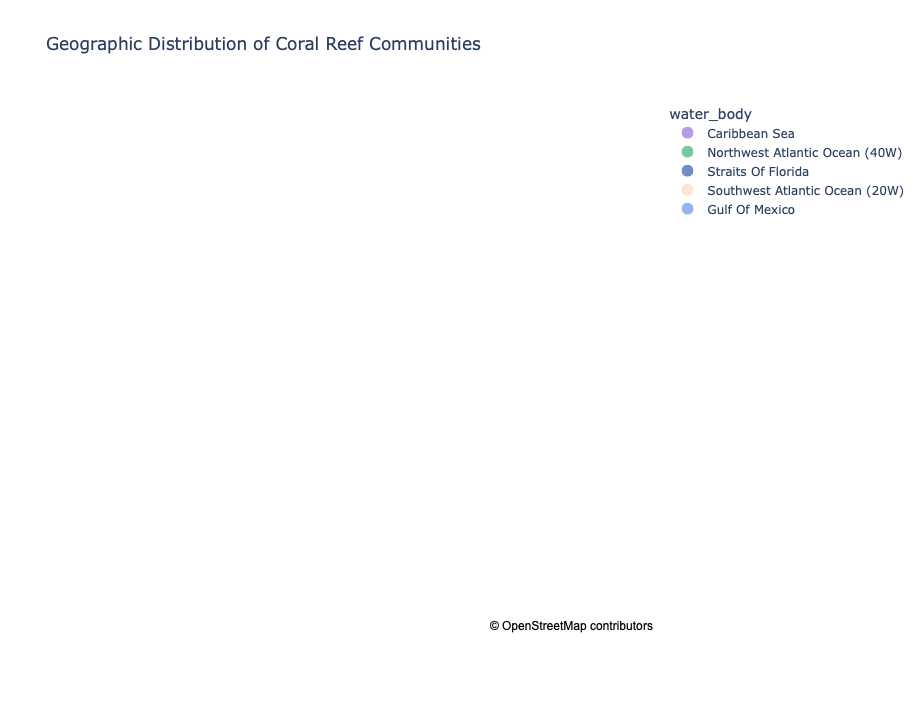

In [12]:
fig = px.scatter_map(
    reef_communities,
    lat = "latitude",
    lon = "longitude",
    color = "water_body",
    #color_continuous_scale = px.colors.cyclical.IceFire,
    color_discrete_sequence = ["mediumpurple", "mediumseagreen", "#3260a5", "peachpuff", "cornflowerblue"],
    size = "individual_count",
    size_max = 15,
    zoom = 3,
    map_style = "open-street-map",
    # control size of plot
    height = 700,
    width = 900,
    title = "Geographic Distribution of Coral Reef Communities"
)

fig.show()

## Corals identification

### Hard corals (scleractinia/stony corals):
- Reef-building: These corals are the primary builders of coral reefs, forming complex structures from calcium carbonate. 
- Examples: Staghorn coral (Acropora cervicornis), Elkhorn coral, Brain coral (Diploria labyrinthiformis), Pillar coral (Dendrogyra cylindrus). 
- Polyp Structure: They typically have six tentacles per polyp. 

### Soft corals (alcyonacea/ahermatypic corals):
- Non-reef builders: These corals do not have hard skeletons and do not contribute to reef formation. 
- Examples: Bubble coral (Plerogyra), soft corals like those found in the order Alcyonacea. 
- Polyp Structure: They have eight feather-like tentacles per polyp. 

### Other coral types:
- Fire Corals (Hydrozoa): These resemble hard corals but belong to the class Hydrozoa and have stinging cells. 
- Solitary Corals: Live as individuals rather than in colonies, some thrive in colder waters. 
- Fungiidae (Mushroom Corals): Solitary, disc-shaped corals. 
- Black Corals (Antipatharia): Known for their dark color, their skeletons are chitin-based. 

In [13]:
def openai_corals_check(open_api_key, target_species, openai_request, format_request,
                        open_azure_endpoint = "https://sweden-chatgpt.openai.azure.com/",
                        open_api_version = "2024-08-01-preview",
                        model_name = "swcentral-chatgpt-4o"):

    client = AzureOpenAI(
        api_key = open_api_key,
        azure_endpoint = open_azure_endpoint,
        api_version = open_api_version,
    )

    # build the full prompt by appending the target species and any formatting instructions
    openai_request = openai_request + f"{target_species}" + format_request
    
    # send the prompt to the model and request a completion
    completion = client.chat.completions.create(
        model = model_name,
        messages = [
            {
                "role": "user",
                "content": openai_request,
            },
        ],
        response_format = {"type": "json_object"},
        temperature = 0.5, # controls the randomness of the generated text, ranging from 0 (deterministic) to 2 (more random)
    )
    
    return completion.choices[0].message.content

In [14]:
openai_request = """
                    Based on this list of marine species names: 
                """ 
format_request = """

                    Classify them into scleractinian coral, stony coral, alcyonacea, ahermatypic coral,
                    fire coral, solitary coral, fungiidae (mushroom coral), black coral,
                    deep-water coral, or any other suitable type. In addition, include a flag that tells
                    whether a coral specie is reef building. Please, provide the response in json
                    format in the form:

                    {
                        coral_types: {
                            specie_name_in_dataset: (coral_type, 1 or 0)
                        }
                    }

                """

In [15]:
jumps = 150 # 90 150 325
target_api_runs = 3
coral_types_comparisson = []
target_species = reef_communities["valid_scientific_name"].unique().tolist()

# run the same request 3 times to compare results
for _ in range(target_api_runs):
    openai_corals = {}
    non_coral_species_per_run = []

    # check by batches because the API has a character limit
    for idx in range(0, len(target_species), jumps):
        partitioned_target_species = target_species[idx:idx+jumps]
        
        openai_corals_str = openai_corals_check(
            open_api_key = open_api_key,
            #target_species = data.scientific_name.unique().tolist(),

            # make sure not to compare already identified species
            target_species = partitioned_target_species, #species_list, # 7,506
            openai_request = openai_request,
            format_request = format_request,
        )

        openai_coral_request = json.loads(openai_corals_str)
        # collect non coral species
        # append: [[], [], []]
        # extend: [..] + [...] = [.....] 
        #non_coral_species_per_run.extend(openai_coral_request["non_coral_species_or_not_associated_with_corals"])

        # collect coral types
        openai_corals = {**openai_coral_request["coral_types"], **openai_corals}

    # save results from differen API runs
    #coral_types_comparisson.append(
    #    {
    #        # only keep species that are different from their fixed names
    #        # coral_name != coral_fixed_name
    #        coral_sp: openai_corals[coral_sp]
    #        for coral_sp in openai_corals
    #        if coral_sp != openai_corals[coral_sp]
    #    }
    #)
    coral_types_comparisson.append(openai_corals)

# intersection between all runs
coral_species_types = list(
    set(coral_types_comparisson[0]) & set(coral_types_comparisson[1]) & set(coral_types_comparisson[2])
)

In [16]:
# track all [type, reef_building_flag] values per species
coral_tracker = defaultdict(set)

for coral_dict in coral_types_comparisson:  # api_runs = your list of dicts
    for species, value in coral_dict.items():
        coral_tracker[species].add(tuple(value))  # Convert list to tuple to make it hashable

# identify inconsistent species
conflicts = {species: values for species, values in coral_tracker.items() if len(values) > 1}

# display inconsistent entries
if conflicts:
    print("❌ Inconsistent species found across API runs:")
    for species, entries in conflicts.items():
        print(f"  {species}: {entries}")
else:
    print("✅ All species are consistent across API runs.")

# remove inconsistent species from each run
#filtered_runs = [
#    {k: v for k, v in coral_dict.items() if k not in conflicts}
#    for coral_dict in coral_types_comparisson
#]

# combine consistent results into a single dict (last run wins if repeated)
#unified_species_info = {}
#for coral_dict in filtered_runs:
#    unified_species_info.update(coral_dict)

# remove inconsistent species only from the first run
filtered_first_run = {
    k: v for k, v in coral_types_comparisson[0].items() if k not in conflicts
}

filtered_first_run = {
    k: {
        "type": v[0],
        "is_reef_building": v[1]
    }
    
    for k,v in filtered_first_run.items()
}

print(f"{len(filtered_first_run)} consistent species retained.")
print(f"{len(conflicts)} inconsistent species removed.")

❌ Inconsistent species found across API runs:
  scolymia lacera: {('scleractinian coral', 0), ('solitary coral', 0)}
  solenastrea hyades: {('scleractinian coral', 0), ('scleractinian coral', 1)}
  mussismilia harttii: {('scleractinian coral', 0), ('scleractinian coral', 1)}
  solenastrea bournoni: {('scleractinian coral', 0), ('scleractinian coral', 1)}
  mussismilia braziliensis: {('scleractinian coral', 0), ('scleractinian coral', 1)}
  mussa angulosa: {('scleractinian coral', 0), ('solitary coral', 0)}
  mussismilia hispida: {('scleractinian coral', 0), ('scleractinian coral', 1)}
  scolymia cubensis: {('scleractinian coral', 0), ('solitary coral', 0)}
57 consistent species retained.
8 inconsistent species removed.


In [17]:
# add specie type and whether is reef building to the dataset
reef_communities["species_type"] = reef_communities["valid_scientific_name"].apply(
    lambda name: filtered_first_run.get(name, {}).get("type")
)

reef_communities["is_reef_building"] = reef_communities["valid_scientific_name"].map(
    lambda name: filtered_first_run.get(name, {}).get("is_reef_building")
)

# keep null vaslues
reef_communities["is_reef_building"] = reef_communities["is_reef_building"].astype(str)
replacements = {'1.0': 'true', '0.0': 'false', 'nan':'unknown'}
reef_communities = reef_communities.replace(replacements)


reef_communities.head(3)

,scientific_name,valid_scientific_name,matching_type,unaccept_reason,rank,latitude,longitude,minimum_depth_in_meters,maximum_depth_in_meters,event_date,individual_count,country,ocean,water_body,heritage_site,species_type,is_reef_building
0,millepora alcicornis,millepora alcicornis,accepted,None,species,18.312466,-65.335449,6.4,6.6,2003-09-26,2,United States,North Atlantic Ocean,Caribbean Sea,unknown,fire coral,false
1,porites porites,porites porites,accepted,None,species,21.303350,-71.223137,9.0,11.0,1999-08-16,1,Turks and Caicos Islands,North Atlantic Ocean,Caribbean Sea,unknown,scleractinian coral,true
2,montastraea cavernosa,montastraea cavernosa,accepted,None,species,17.643333,-63.253166,5.2,5.2,1999-12-09,1,Netherlands,unknown,Caribbean Sea,unknown,scleractinian coral,true


In [18]:
gdf = gpd.GeoDataFrame(
    reef_communities,
    geometry=gpd.points_from_xy(reef_communities["longitude"], reef_communities["latitude"]),
    crs="EPSG:4326",
    #crs = "EPSG:3857",
)
gdf.head()

,scientific_name,valid_scientific_name,matching_type,unaccept_reason,rank,latitude,longitude,minimum_depth_in_meters,maximum_depth_in_meters,event_date,individual_count,country,ocean,water_body,heritage_site,species_type,is_reef_building,geometry
0,millepora alcicornis,millepora alcicornis,accepted,None,species,18.312466,-65.335449,6.4,6.6,2003-09-26,2,United States,North Atlantic Ocean,Caribbean Sea,unknown,fire coral,false,POINT (-65.33545 18.31247)
1,porites porites,porites porites,accepted,None,species,21.303350,-71.223137,9.0,11.0,1999-08-16,1,Turks and Caicos Islands,North Atlantic Ocean,Caribbean Sea,unknown,scleractinian coral,true,POINT (-71.22314 21.30335)
2,montastraea cavernosa,montastraea cavernosa,accepted,None,species,17.643333,-63.253166,5.2,5.2,1999-12-09,1,Netherlands,unknown,Caribbean Sea,unknown,scleractinian coral,true,POINT (-63.25317 17.64333)
3,montastraea cavernosa,montastraea cavernosa,accepted,None,species,18.260300,-78.365349,12.1,12.1,2000-08-14,1,Jamaica,unknown,Caribbean Sea,unknown,scleractinian coral,true,POINT (-78.36535 18.2603)
4,dichocoenia stokesi,dichocoenia stokesii,misspelling - incorrect subsequent spelling,None,species,26.353500,-76.977997,8.5,8.5,1999-08-15,1,Bahamas,North Atlantic Ocean,Northwest Atlantic Ocean (40W),unknown,scleractinian coral,false,POINT (-76.978 26.3535)


In [19]:
# sample down for interactivity performance
sample_n = 5000
if len(gdf) > sample_n:
    rc_fol = gdf.sample(sample_n, random_state=42)
else:
    rc_fol = gdf

m = folium.Map(location=[0, 0], zoom_start=2, tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(m)


def _popup(row):
    ocean = row.get("ocean", "?")
    wb = row.get("water_body", "?")
    sp = row.get("species_type", "?")
    rb = row.get("is_reef_building", "?")
    return f"<b>Ocean:</b> {ocean}<br><b>Water body:</b> {wb}<br><b>Species type:</b> {sp}<br><b>Reef-building:</b> {rb}"

for _, r in rc_fol.iterrows():
    folium.CircleMarker(
        location=[r.geometry.y, r.geometry.x],
        radius=3,
        fill=True,
        popup=folium.Popup(_popup(r), max_width=300)
    ).add_to(marker_cluster)

out_html = Path("reef_map_interactive.html")
m.save(out_html)
#print(f"Saved interactive map to {out_html.resolve()} – open in a browser.")

In [20]:
# update table schema
reef_communities_dataset.table.alter(
    pa.schema([
        pa.field("scientific_name", pa.string(),
             metadata = {"description": "The scientific name of the species"}),
        pa.field("valid_scientific_name", pa.string(),
                 metadata = {"description": "The scientific name of the species according to WoRMS"}),
        pa.field("matching_type", pa.string(),
                 metadata = {
                     "description": """
                     Taxonomic status or relationship of the matched scientific name.
                     Values reflect how the name in the dataset corresponds to current taxonomic standards
                     """
                 }),
        pa.field("unaccept_reason", pa.string(),
                 metadata = {"description": "Reason why the name is not accepted"}),
        pa.field("rank", pa.string(),
                 metadata = {"description": "Taxonomic rank of the species"}),
        pa.field("latitude", pa.float64(),
                 metadata = {"description": "Latitude of the observation"}),
        pa.field("longitude", pa.float64(),
                 metadata = {"description": "Longitude of the observation"}),
        pa.field("minimum_depth_in_meters", pa.float64(),
                 metadata = {"description": "Minimum depth of the observation in meters"}),
        pa.field("maximum_depth_in_meters", pa.float64(),
                 metadata = {"description": "Maximum depth of the observation in meters"}),
        pa.field("event_date", pa.date32(),
                 metadata = {"description": "Date of the observation"}),
        pa.field("individual_count", pa.int64(),
                 metadata = {"description": "Count of individuals observed"}),
        pa.field("country", pa.string(),
                 metadata = {"description": "Country where the observation was made"}),
        pa.field("ocean", pa.string(), nullable = True,
                 metadata = {"description": "Name of the ocean where lat,lon coordinates fall"}),
        pa.field("water_body", pa.string(),
                 metadata = {"description": "Name of the sea subregion where lat,lon coordinates fall"}),
        pa.field("heritage_site", pa.string(),
                 metadata = {"description": "Name of the World Marine Heritage Site where lat,lon coordinates fall (if applies)"}),
        pa.field("species_type", pa.string(),
                 metadata = {"description": "Name of the coral specie type"}),
        #pa.field("is_reef_building", pa.bool_(), nullable = True)
        pa.field("is_reef_building", pa.string(), nullable = True,
                 metadata = {"description": "Flag that identifies if the coral type is reef-builder or not"}),
        pa.field("wkt_coordinates", pa.string(),
                 metadata = {"description": "Coordinates of the observation in WKT format",
                            "isGeometry": "1"})
    ])
)

{}

In [21]:
%%time
with reef_communities_dataset as tx:
  tx.delete("1=1")  # drop the data, keep the schema
  tx.insert(reef_communities)

CPU times: user 389 ms, sys: 65.2 ms, total: 454 ms
Wall time: 8.42 s
